In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
np.random.seed(42) 
m = 100
X = 6 * np.random.rand(m, 1) - 3
y = 0.5 * X ** 2 + X + 2 + np.random.randn(m, 1)


[[0.00026602]
 [0.00035539]] [3.41199385]
[[0.00026602 0.00035539]] [3.41199385]
(100, 2) (100, 1)


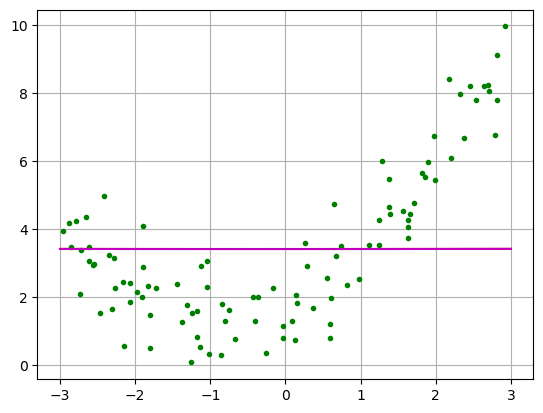

In [3]:
from regression import LinearRegression
from sklearn.linear_model import Ridge as SKRidge
from sklearn.linear_model import LinearRegression as SKLinearRegression 

class Ridge():
  def __init__(self, alpha) -> None:
    self.alpha = alpha

  def __add_bias(self, X):
    return np.c_[np.ones((X.T.shape[-1],1)), X]
  
  def fit(self, X, y):
    X_b = self.__add_bias(X)
    A = np.identity(X_b.shape[1])
    A[0, 0] = 0
    self.theta = np.linalg.inv(X_b.T @ X_b  + self.alpha * A) @ X_b.T @ y
    self.intercept_ = self.theta[0]
    self.coef_ = self.theta[1:]

    
  def predict(self, X):
    return self.__add_bias(X) @ self.theta

X_poly = np.c_[X, np.power(X, 2)]
X_test = np.linspace(-3, 3, m).reshape(m, 1)

X_poly_test = np.c_[X_test, np.power(X_test, 2)]

plt.plot(X, y, "g.", label="Predictions")

alpha = 1000000.0

lr = Ridge(alpha=alpha)
lr.fit(X_poly, y)
print(lr.coef_, lr.intercept_)

y_pred = lr.predict(X_poly_test)

plt.plot(X_test, y_pred, "r-")


lr2 = SKRidge(alpha=alpha, solver="cholesky")
lr2.fit(X_poly, y)
print(lr2.coef_, lr2.intercept_)

y_pred_reg = lr2.predict(X_poly_test)
print(X_poly.shape, y_pred.shape)
plt.plot(X_test, y_pred_reg, "m-")

# plt.scatter(X, y)
plt.grid(True)
plt.show()

[[0.39181762]
 [0.49347281]] [3.41315212]
[-0.00671837  0.03801852] [1.05255967]
(100, 2) (100,)


c:\Users\Vadim\anaconda3\lib\site-packages\sklearn\utils\validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Vadim\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1551: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


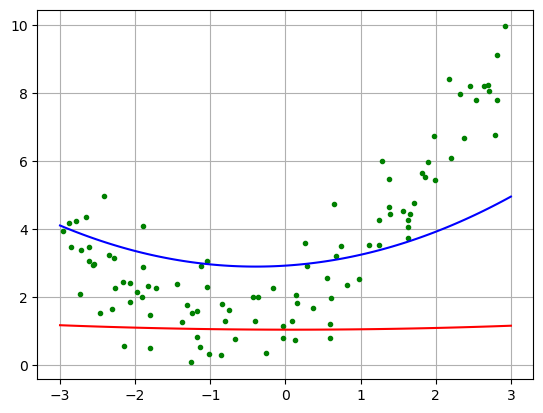

In [4]:
from sklearn.linear_model import SGDRegressor
#from regression import SGDRegression
from utils import StandardScaler


class SGDRegression():
    def __init__(self, n_iter, eta0, seed = None, penalty="", alpha = None, r=None, lr0=None, lr1=None) -> None:
        self.n_iter = n_iter
        self.penalty = penalty
        self.lr0 = lr0
        self.lr1 = lr1
        self.eta0 = eta0
        assert not ((penalty == "") and (alpha != None)), "Alpha must be none, when penalty is empty"
        self.alpha = alpha
        if (penalty == "elastic") and (r == None):
           raise Exception("r value for elastic net is None")
        if (penalty == "elastic") and ((r >= 1) or (r < 0)):
           raise Exception("r must be (r <= 1)  (r > 0)")
        self.r = r

        if seed is not None:
            self.rng = np.random.default_rng(seed=seed)


    def __add_bias(self, X):
        return np.c_[np.ones((X.T.shape[-1],1)), X]
  
    def learning_schedule(self, t):
        return self.lr0 / (t + self.lr1)
    
    def learning_schedule_optimal(self, t):
        #optimal_init = 1.0 / (self.eta0 * m)
        return 1 / (t + self.eta0)

    def fit(self, X:np.ndarray, y):
        X_b = self.__add_bias(X)
        #X_b = X.copy()
       
        self.theta = self.rng.standard_normal((X_b.shape[1], 1))

        # self.coef_ = self.rng.standard_normal((X_b.shape[1] - 1, 1))
        # self.intercept_ = self.rng.standard_normal((1, 1))

        m = len(X_b)

        for epoch in range(self.n_iter):
            for iteration in range(m):
                sample_index =  self.rng.integers(m)
                Xi = X_b[sample_index: sample_index+1]
                yi = y[sample_index: sample_index+1]

                if self.penalty == "l1":
                    l1 = self.alpha * np.sign(self.theta)
                    l1[0] = 0
                    gradient = 2 * Xi.T @ (Xi @ self.theta - yi) + l1

                elif self.penalty == "l2":
                    l2 = 2 * self.alpha * self.theta
                    l2[0] = 0
                    gradient = 2 * Xi.T @ (Xi @ self.theta - yi) + l2

                elif self.penalty == "elastic":
                    l1 = self.alpha * np.sign(self.theta)
                    l1[0] = 0
                    l2 = 2 * self.alpha * self.theta
                    l2[0] = 0

                    gradient = 2 * Xi.T @ (Xi @ self.theta - yi) + self.r * l1 + (1-self.r) * l2

                eta = self.learning_schedule_optimal(epoch * m + iteration + 1)

                self.theta -= eta * gradient


        self.intercept_ = self.theta[0]
        self.coef_ = self.theta[1:]

    def predict(self, X):
        return self.__add_bias(X) @ self.theta

    
    
X_poly = np.c_[X, np.power(X, 2)]
X_test = np.linspace(-3, 3, m).reshape(m, 1)

std_scaler = StandardScaler()

X_poly_scaled = std_scaler.fit_transform(X_poly)


X_poly_test = np.c_[X_test, np.power(X_test, 2)]
X_poly_test_scaled = std_scaler.fit_transform(X_poly_test)


plt.plot(X, y, "g.", label="Predictions")

sgd = SGDRegression(n_iter=14, eta0=0.01, seed=42, penalty="elastic", alpha=2, r=0.1)
sgd.fit(X_poly_scaled, y)
print(sgd.coef_, sgd.intercept_)

y_pred = sgd.predict(X_poly_test_scaled)

plt.plot(X_test, y_pred, "b-")


lr2 =  SGDRegressor(max_iter=1, eta0=0.01, random_state=42, penalty="l2",  alpha=70, learning_rate="optimal")
lr2.fit(X_poly_scaled, y)
print(lr2.coef_, lr2.intercept_)  

y_pred_reg = lr2.predict(X_poly_test_scaled)
print(X_poly_scaled.shape, y_pred_reg.shape)
plt.plot(X_test, y_pred_reg, "r-")



#plt.axis([-5, 5, -5, 10])

# plt.scatter(X, y)
plt.grid(True)
plt.show()


In [5]:
from sklearn.datasets import load_iris
from sklearn.metrics import accuracy_score, recall_score, precision_score
from utils import sigmoid

class LogisticRegression():
    def __init__(self, n_iter, eta0, seed = None) -> None:
        self.n_iter = n_iter
        self.eta0 = eta0
        
        if seed is not None:
            self.rng = np.random.default_rng(seed=seed)
        else:
            self.rng = np.random.default_rng()
    
    def learning_schedule_optimal(self, t):
        return 1 / (t + self.eta0)
    
    def __add_bias(self, X):
        return np.c_[np.ones((X.T.shape[-1],1)), X]
  

    def fit(self, X, y):

        X_b = self.__add_bias(X)

        self.theta = self.rng.standard_normal((X_b.shape[1], 1))

        m = len(X_b)

        for epoch in range(self.n_iter):
            for iteration in range(m):
                sample_index =  self.rng.integers(m)
                Xi = X_b[sample_index: sample_index+1]
                yi = y[sample_index: sample_index+1]

                gradient = 2 * Xi.T @ (sigmoid(Xi @ self.theta) - yi)

                eta = self.learning_schedule_optimal(epoch * m + iteration + 1)

                self.theta -= eta * gradient

        self.intercept_ = self.theta[0]
        self.coef_ = self.theta[1:].T

    def predict(self, X):
        pred = self.predict_proba(X)
        return np.where(pred > 0.5, 1, 0)
    

    def predict_proba(self, X):
        return sigmoid(self.__add_bias(X) @ self.theta)
    

In [6]:
from sklearn.datasets import make_classification

# create features and target
toy_X_clf, toy_y_clf = make_classification(n_samples=300,
                                      n_features=2,
                                      n_informative=2,
                                      n_redundant=0,
                                      n_classes=2,
                                      weights=[0.5, 0.5], class_sep=20,hypercube=False, random_state=42)

# print features and target

class_1 = toy_y_clf == 0
class_2 = toy_y_clf == 1



In [7]:
from sklearn.linear_model import LogisticRegression as LogisticRegressionSK

log_reg = LogisticRegression(n_iter=100, eta0=0.01)
log_reg.fit(toy_X_clf, toy_y_clf)
print(log_reg.predict(toy_X_clf[:4]),log_reg.predict_proba(toy_X_clf[:4]),  toy_y_clf[:4])

log_reg_sk = LogisticRegressionSK()
log_reg_sk.fit(toy_X_clf, toy_y_clf)
print(log_reg_sk.predict(toy_X_clf[:4]), toy_y_clf[:4])
print(log_reg_sk.coef_, log_reg.coef_)

[[1]
 [0]
 [1]
 [1]] [[0.99902384]
 [0.0299491 ]
 [0.99958534]
 [0.99842916]] [1 0 1 1]
[1 0 1 1] [1 0 1 1]
[[0.70861344 3.1565525 ]] [[0.58944809 2.47934688]]


In [8]:
def plot_decsision_line(model, X, color="k", ls="--"):
    c = -model.intercept_/model.coef_[0][1] 
    m = -model.coef_[0][0] /model.coef_[0][1] 
    xd = np.array(X)
    yd = m*xd + c

    plt.plot(xd, yd, color, lw=1, ls=ls)

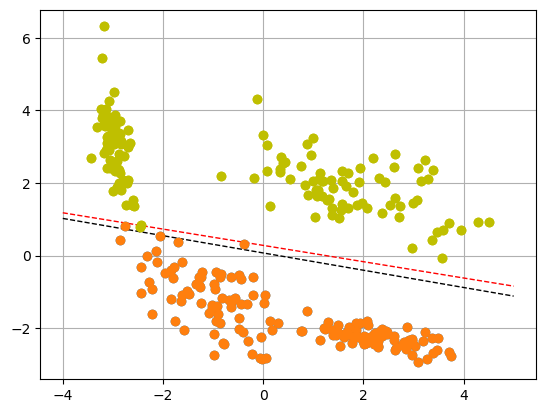

In [9]:
plt.plot(toy_X_clf[class_1][:,0], toy_X_clf[class_1][:,1], "o")
plt.plot(toy_X_clf[class_2][:,0], toy_X_clf[class_2][:,1], "yo")
#Line

plot_decsision_line(log_reg,X=[-4, 5], color="k", ls="--")

plot_decsision_line(log_reg_sk,X=[-4, 5], color="r", ls="--")

plt.plot(toy_X_clf[class_1][:,0], toy_X_clf[class_1][:,1], "o")
plt.plot(toy_X_clf[class_2][:,0], toy_X_clf[class_2][:,1], "yo")

plt.grid(True)
plt.show()


In [10]:
data_iris = load_iris()
names = data_iris.target_names
X_idx = (data_iris.target == 0) | (data_iris.target == 1)
X_idx, names

(array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
      

In [11]:
from sklearn.model_selection import train_test_split

X_train, y_train = data_iris.data[X_idx], data_iris.target[X_idx]
X_train,X_test,  y_train,  y_test = train_test_split(X_train, y_train, test_size=0.2)

X_train[-4:], y_train[-4:], X_test[-4:], y_test[-4:]

(array([[5.7, 2.9, 4.2, 1.3],
        [4.7, 3.2, 1.6, 0.2],
        [5.4, 3.4, 1.7, 0.2],
        [6.2, 2.9, 4.3, 1.3]]),
 array([1, 0, 0, 1]),
 array([[5. , 3.6, 1.4, 0.2],
        [5.4, 3.7, 1.5, 0.2],
        [5.6, 2.5, 3.9, 1.1],
        [5.5, 2.4, 3.7, 1. ]]),
 array([0, 0, 1, 1]))

In [12]:
log_reg = LogisticRegression(n_iter=20, eta0=0.01)
log_reg.fit(X_train, y_train)
print(y_test, log_reg.predict(X_test).T)
print(accuracy_score(y_test, log_reg.predict(X_test).T.squeeze()))


log_reg_sk = LogisticRegressionSK()
log_reg_sk.fit(X_train, y_train)
print(accuracy_score(y_test, log_reg_sk.predict(X_test).T))


[1 1 1 1 0 1 1 1 1 1 0 1 1 1 0 0 0 0 1 1] [[1 1 1 1 0 1 1 1 1 1 0 1 1 1 0 0 0 0 1 1]]
1.0
1.0


In [13]:
from regression import LogisticRegression as LogisticRegressionLib

log_reg = LogisticRegressionLib(n_iter=20, eta0=0.01)
log_reg.fit(X_train, y_train)
print(y_test, log_reg.predict(X_test).T)
print(accuracy_score(y_test, log_reg.predict(X_test).T.squeeze()))


log_reg_sk = LogisticRegressionSK()
log_reg_sk.fit(X_train, y_train)
print(accuracy_score(y_test, log_reg_sk.predict(X_test).T))

[1 1 1 1 0 1 1 1 1 1 0 1 1 1 0 0 0 0 1 1] [[1 1 1 1 0 1 1 1 1 1 0 1 1 1 0 0 0 0 1 1]]
1.0
1.0


In [14]:
from utils import OneHotEncoder, softmax

class SoftmaxRegression():
    def __init__(self, n_iter=3000, eta0=0.01, seed = None) -> None:
        self.n_iter = n_iter
        self.eta0 = eta0
        
        if seed is not None:
            self.rng = np.random.default_rng(seed=seed)
        else:
            self.rng = np.random.default_rng()
    
    def learning_schedule_optimal(self, t):
        return 1 / (t + self.eta0)
    
    def __add_bias(self, X):
        return np.c_[np.ones((X.T.shape[-1],1)), X]

    def fit(self, X, y):

        y_oh = OneHotEncoder().transform(y)

        self.num_features_ =  X.shape[1]
        self.num_classes_ =  y_oh.shape[1]
        
        X_b = self.__add_bias(X)

         # Randomly intialize weights using glorot uniform intializer.
        #limit = np.sqrt(2 / self.num_features_ + 1)

        #self.__theta = self.rng.uniform(-limit, limit, (self.num_features_ + 1, self.num_classes_))

        self.__theta = self.rng.standard_normal((self.num_features_ + 1, self.num_classes_))
        self.__theta[0] = 1
        print(self.__theta)

        m = len(X_b)

        for epoch in range(self.n_iter):
            for iteration in range(m):
                sample_index =  self.rng.integers(m)
                Xi = X_b[sample_index: sample_index+1]
                yi = y_oh[sample_index: sample_index+1]

                y_pred = Xi @ self.__theta

                y_pred_proba = softmax(y_pred)

                gradient = Xi.T @ (y_pred_proba - yi)
                
                eta = self.eta0 #self.learning_schedule_optimal(epoch * m + iteration + 1)

                self.__theta -= eta * gradient

        self.intercept_ = self.__theta[0]
        self.coef_ = self.__theta[1:].T

    def predict(self, X):
        pred = self.predict_proba(X)
        return np.argmax(pred, axis=1)

    def predict_proba(self, X):
        return softmax(self.__add_bias(X) @ self.__theta)
    

X_iris, y_iris = data_iris.data, data_iris.target

X_train_all, X_test_all,  y_train_all,  y_test_all = train_test_split(X_iris, y_iris, test_size=0.5, random_state=42, shuffle=True)

#X_train_all[-4:], y_train_all[-4:], X_test_all[-4:], y_test_all[-4:]

softmax_reg = SoftmaxRegression(n_iter=10, eta0=0.1, seed=42)
softmax_reg.fit(X_train_all, y_train_all)
#softmax_reg.predict_proba(X_test_all), 
np.set_printoptions(suppress = True)
print( softmax_reg.predict(X_test_all), y_test_all)
print( softmax_reg.predict_proba(X_test_all))

print(accuracy_score(y_test_all, softmax_reg.predict(X_test_all)))

[[ 1.          1.          1.        ]
 [ 0.94056472 -1.95103519 -1.30217951]
 [ 0.1278404  -0.31624259 -0.01680116]
 [-0.85304393  0.87939797  0.77779194]
 [ 0.0660307   1.12724121  0.46750934]]
[1 0 2 1 1 0 1 2 1 1 2 0 0 0 0 1 2 1 1 2 0 2 0 2 1 2 2 2 0 0 0 0 1 0 0 2 1
 0 0 0 2 1 1 0 0 1 1 2 1 2 1 2 1 0 2 1 0 0 0 1 2 0 0 0 1 0 1 2 0 1 2 0 2 2
 1] [1 0 2 1 1 0 1 2 1 1 2 0 0 0 0 1 2 1 1 2 0 2 0 2 2 2 2 2 0 0 0 0 1 0 0 2 1
 0 0 0 2 1 1 0 0 1 2 2 1 2 1 2 1 0 2 1 0 0 0 1 2 0 0 0 1 0 1 2 0 1 2 0 2 2
 1]
[[0.00122736 0.97565356 0.02311909]
 [0.99103475 0.00896525 0.        ]
 [0.         0.00033297 0.99966703]
 [0.0028165  0.94562911 0.0515544 ]
 [0.00138153 0.9946797  0.00393877]
 [0.98785381 0.01214619 0.        ]
 [0.04105772 0.95835921 0.00058306]
 [0.00051767 0.42117009 0.57831224]
 [0.00073962 0.92548283 0.07377755]
 [0.01159469 0.98730693 0.00109838]
 [0.00045155 0.39703054 0.60251791]
 [0.97122527 0.02877473 0.        ]
 [0.99485838 0.00514162 0.        ]
 [0.96929313 0.03070687 0.  

In [15]:
softmax(np.array([[3, 4, 1]]))

array([[0.25949646, 0.70538451, 0.03511903]])

In [16]:

softmax_reg_sk = LogisticRegressionSK(C=30, random_state=42)

softmax_reg_sk.fit(X_train_all, y_train_all)
print(softmax_reg_sk.coef_.T, softmax_reg_sk.intercept_.T)
print(y_test_all, softmax_reg_sk.predict(X_test_all).T)
print(accuracy_score(y_test_all, softmax_reg_sk.predict(X_test_all).T))

[[ 0.58016125  0.63337558 -1.21353683]
 [ 2.36968454  0.68820922 -3.05789376]
 [-4.99018025 -0.50888914  5.49906939]
 [-2.24657029 -2.8028821   5.04945238]] [ 11.22085583   4.89615213 -16.11700796]
[1 0 2 1 1 0 1 2 1 1 2 0 0 0 0 1 2 1 1 2 0 2 0 2 2 2 2 2 0 0 0 0 1 0 0 2 1
 0 0 0 2 1 1 0 0 1 2 2 1 2 1 2 1 0 2 1 0 0 0 1 2 0 0 0 1 0 1 2 0 1 2 0 2 2
 1] [1 0 2 1 1 0 1 2 1 1 2 0 0 0 0 1 2 1 1 2 0 2 0 2 2 2 2 2 0 0 0 0 1 0 0 2 1
 0 0 0 2 1 1 0 0 1 1 2 1 2 1 2 1 0 2 1 0 0 0 1 2 0 0 0 1 0 1 2 0 1 2 0 1 2
 1]
0.9733333333333334


c:\Users\Vadim\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Plot logistic regression plot with pred from 0 to 1

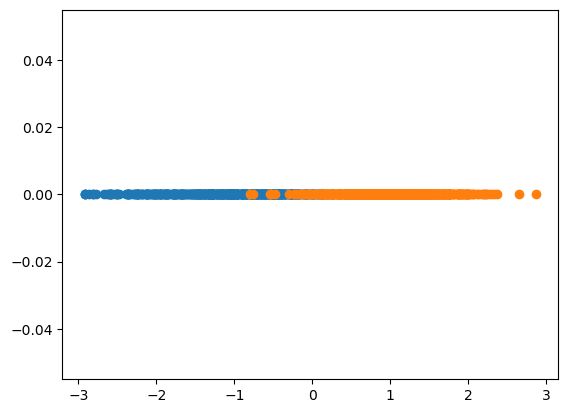

In [50]:
import pandas as pd
from sklearn.datasets import make_classification
X_2d_cf,y_2d_cf = make_classification(n_samples=1000, n_features=1, n_informative=1, 
                    n_redundant=0, n_repeated=0, n_classes=2, n_clusters_per_class=1,
                    class_sep=1,
                    flip_y=0,weights=[0.4,0.5])


df = pd.DataFrame()
df["x0"] = X_2d_cf[:,0]
#df["x1"] = X_2d_cf[:,1]

df["y"] = y_2d_cf

plt.scatter(df[df["y"] == 0]["x0"], np.zeros(len(df[df["y"] == 0]["x0"]))) #, df[df["y"] == 0]["x1"])
plt.scatter(df[df["y"] == 1]["x0"], np.zeros(len(df[df["y"] == 1]["x0"]))) #df[df["y"] == 1]["x1"])



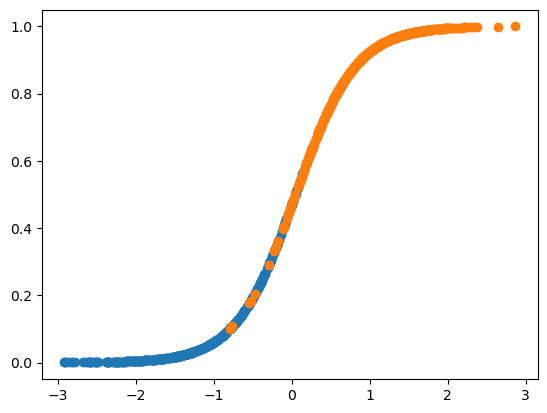

In [56]:
log_reg_cf_synthetic = LogisticRegressionLib(1000, 0.1)
log_reg_cf_synthetic.fit(X_2d_cf, y_2d_cf)

plt.scatter(df[df["y"] == 0]["x0"], log_reg_cf_synthetic.predict_proba(df[df["y"] == 0]["x0"]))
plt.scatter(df[df["y"] == 1]["x0"], log_reg_cf_synthetic.predict_proba(df[df["y"] == 1]["x0"]))